In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


#Prepare dataset

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
candidate_items = pd.read_csv('/gdrive/MyDrive/dressipi_recsys2022_mapped/dataset/processed_data/candidate_items_mapped.csv')
candidate_items.head()

,item_id
0,1
1,2
2,3
3,4
4,5


In [ ]:
embedding_weights = np.load(
    '/gdrive/MyDrive/dressipi_recsys2022_mapped/dataset/processed_data/compressed_features.npy'
    )

embedding_weights

array([[-2.9421203 ,  0.9019071 ,  1.006472  , ..., -0.60168713,
        -0.99741495, -2.176776  ],
       [ 1.3457017 , -5.7418914 , -2.526616  , ..., -1.0471164 ,
        -1.0043366 , -2.4690313 ],
       [-1.3519735 , -3.5611124 , -2.8582397 , ..., -0.7454028 ,
        -0.95639294, -2.2310395 ],
       ...,
       [-0.15950966,  0.42464903,  2.9911358 , ..., -0.76466924,
        -0.95495176, -2.3828921 ],
       [-2.1240826 , -1.3623403 , -1.5015457 , ..., -0.9137608 ,
        -1.1719595 , -2.572146  ],
       [-2.5682082 , -2.9699187 , -0.687831  , ..., -0.905792  ,
        -1.1627257 , -2.4262748 ]], dtype=float32)

In [ ]:
print('The highest candidate item id is {}'.format(max(candidate_items['item_id'])))

The highest candidate item id is 4990


In [ ]:
train_sessions = pd.read_csv(
    '/gdrive/MyDrive/dressipi_recsys2022_mapped/dataset/processed_data/train_sessions_mapped.csv',
    parse_dates=['date'], 
    infer_datetime_format=True
    )

In [ ]:
train_sessions = train_sessions[['session_id', 'item_id']].groupby(['session_id']).agg(tuple).applymap(list).reset_index()
train_sessions.head()

,session_id,item_id
0,3,"[9769, 9769]"
1,13,[12783]
2,18,"[14116, 6166, 6924]"
3,19,"[4546, 8092, 17752, 14975, 9083, 9079, 7096, 8..."
4,24,"[6381, 10784, 6381, 23669, 5215, 2842, 10162, ..."


In [ ]:
train_sessions.sort_values(by="session_id",inplace=True)

In [ ]:
train_sessions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   session_id  1000000 non-null  int64 
 1   item_id     1000000 non-null  object
dtypes: int64(1), object(1)
memory usage: 22.9+ MB


In [ ]:
train_purchases = pd.read_csv(
    '/gdrive/MyDrive/dressipi_recsys2022_mapped/dataset/processed_data/train_purchases_mapped.csv',
    parse_dates=['date'], 
    infer_datetime_format=True
    )
train_purchases.head()

,session_id,item_id,date
0,3,12492,2020-12-18 21:26:47.986
1,13,3299,2020-03-13 19:36:15.507
2,18,17411,2020-08-26 19:20:32.049
3,19,11229,2020-11-02 17:16:45.920
4,24,11568,2020-02-26 18:27:44.114


In [ ]:
train_purchases.sort_values(by="session_id",inplace=True)

In [ ]:
x = tf.keras.preprocessing.sequence.pad_sequences(
    train_sessions['item_id'], 
    padding='post'
)

In [ ]:
y = train_purchases['item_id'].to_numpy()

In [ ]:
y_features = embedding_weights[y]

In [ ]:
x_train, x_test, y_train, y_test, y_features_train, y_features_test = train_test_split(
    x, 
    y, 
    y_features, 
    test_size=0.2,
    random_state=1234
    )

print(x_train[0])
print(y_train[0])
print(y_features_train[0])

[18893     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
16055
[-6.80534959e-01 -2.97601223e+00 -3.33461714e+00  2.11141920e+00
  1.91265488e+00  1.14349216e-01 -4.89112663e+00  6.51130676e-01
 -2.18067098e+00  8.89882207e-01  1.40744543e+00  1.20458412e+00
 -9.38825846e-01  1.12501812e+00 -4.11588907e-01 -2.00425982e-01
 -2.27957582e+00 -4.58949506e-01 -1.08444083e+00 -3.65605950e-02
 -1.07230806e+00  1.44384050e+00 -4.08869982e-03  1.4739230

#Build Dataset

In [ ]:
train_set = tf.data.Dataset.from_tensor_slices((x_train, (y_train, y_features_train))).batch(512,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).shuffle(1563, reshuffle_each_iteration=True)
test_set = tf.data.Dataset.from_tensor_slices((x_test, (y_test, y_features_test))).batch(512)

train_set.element_spec

double_output_ds=tf.data.Dataset.from_tensor_slices((y_train,y_train))
input_ds = tf.data.Dataset.from_tensor_slices(x_train)

double_train_set = tf.data.Dataset.zip((input_ds, double_output_ds )).batch(512,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).shuffle(1563, reshuffle_each_iteration=True)

#Transformer net


In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(
        self, 
        maxlen, 
        vocab_size, 
        embed_dim, 
        item_embedding_trainable=True, 
        embedding_weights=None
        ):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, 
            output_dim=embed_dim,
            trainable=item_embedding_trainable,
            weights=embedding_weights
            )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 3  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 100 # Length of the sequence
vocabulary_size =23692 #max(train_purchases['item_id']) # Size of the vocabulary
mlp_width = embedding_weights.shape[1] # Width of the mlp layer
mlp_depth = 3 # Depth of the mlp layer

###### INPUT #####
inputs = layers.Input(shape=(maxlen,), name='input')

##### SEQUENTIAL #####
transformer = tf.keras.Sequential(
    [
     TokenAndPositionEmbedding(
         maxlen, 
         embedding_weights.shape[0], 
         embedding_weights.shape[1],
         item_embedding_trainable=True,
         embedding_weights=[embedding_weights]
         ),
     #layers.Dense(units=mlp_width, activation='relu'),
     #layers.BatchNormalization(),
     TransformerBlock(
         embedding_weights.shape[1], 
         num_heads, 
         ff_dim,
         #rate=0.2
         ),
     layers.GlobalAveragePooling1D()
    ],
    name='transformer'
)

##### MLP #####
mlp_input = transformer(inputs)

x_pre = mlp_input
for _ in range(mlp_depth):
  x_post = layers.Dense(mlp_width, activation='swish')(x_pre)
  x_pre = layers.Add()([x_pre,x_post])
  #x_pre = layers.Dropout(0.2)(x_pre)
  x_pre = layers.BatchNormalization()(x_pre)

mlp = tf.keras.Model(
    inputs=mlp_input, 
    outputs=x_pre, 
    name='multi_layer_perceptron'
    )

##### PREDICTION #####

observed_items = layers.Masking()(inputs)
observed_items = layers.CategoryEncoding(
    num_tokens=vocabulary_size+1, 
    output_mode='multi_hot',
    name="mask_elemens"
    )(observed_items)
observed_items = layers.Lambda(lambda x: x[...,:19021])(observed_items)
candidates = layers.Lambda(lambda x: 1. - x)(observed_items)
outputs=layers.Dense(19020+1, activation='softmax',)(layers.Dropout(0.3)(mlp(transformer((inputs)))))
prediction = layers.Multiply(name='prediction')(
    [
     outputs,
     candidates
    ]
)
prediction = layers.Lambda(lambda x: x[...,:4991])(prediction)

##### MODEL INSTANTIATION #####
#Prediction model
model = tf.keras.Model(
    inputs=inputs,
    outputs=prediction,
    name='transformer_based_model'
)

#training model
model_for_training = tf.keras.Model(
    inputs=inputs,
    outputs=outputs,
    name='transformer_based_model'
)

model_for_training.compile(
    optimizer='adam', 
    loss=lambda y_true, y_pred : tf.keras.losses.categorical_crossentropy(
        tf.squeeze(tf.one_hot(tf.cast(y_true, dtype=tf.int32), 19020+1, axis=-1)),
        y_pred,
        label_smoothing=0.1
    ), 
    metrics=[
             'accuracy', 
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=100)
             ]
    )

model.compile(
    optimizer="adam",#tf.keras.optimizers.Adam(lr=0.002), 
    loss='sparse_categorical_crossentropy', 
    metrics=[
             'accuracy', 
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=100)
             ]
    )

model.summary(expand_nested=True)

Model: "transformer_based_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 100)]        0           []                               
                                                                                                  
 transformer (Sequential)       (None, 64)           1576928     ['input[0][0]']                  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| token_and_position_embedding_1  (None, 100, 64)   1522688     []                               |
|  (TokenAndPositionEmbedding)                                                                   |
|                                                                                                |
| transformer_block_1 (Transform  (None, 100, 64)   54240       []          

#RNN

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 3  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 100 # Length of the sequence
vocabulary_size = 23692 #max(train_purchases['item_id']) # Size of the vocabulary
mlp_width = 32 # Width of the mlp layer
mlp_depth = 3 # Depth of the mlp layer

sequential_part = tf.keras.Sequential(
    [
     tf.keras.layers.Embedding(
         input_dim=embedding_weights.shape[0],
         output_dim=embedding_weights.shape[1],
         weights=[embedding_weights],
         trainable=False,
         mask_zero=True
     ),
     tf.keras.layers.Bidirectional(
         tf.keras.layers.GRU(
         units=128,
         return_sequences=True,
         #activation='relu',
         #recurrent_activation='relu',
         dropout=0.5,
         #recurrent_dropout=0.2
     )),
     tf.keras.layers.Bidirectional(
         tf.keras.layers.GRU(
         units=128,
         #activation='relu',
         #recurrent_activation='relu',
         dropout=0.5,
         #recurrent_dropout=0.2
     )),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(units=1024, activation='swish'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(units=256, activation='swish'),
     tf.keras.layers.BatchNormalization(),
    ]
)
inputs = layers.Input(shape=(maxlen,), name='input')



outputs=layers.Dense(19020+1, activation='softmax',)(layers.Dropout(0.3)(sequential_part(inputs)))

model_for_training = tf.keras.Model(inputs=inputs,outputs=outputs,name="RNN_model_training")




model_for_training.compile(
    optimizer='adam', 
    loss=lambda y_true, y_pred : tf.keras.losses.categorical_crossentropy(
        tf.squeeze(tf.one_hot(tf.cast(y_true, dtype=tf.int32), 19020+1, axis=-1)),
        y_pred,
        label_smoothing=0.1
    ), 
    metrics=[
             'accuracy', 
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=100)
             ]
    )


#Architecture changed only for test set prediction
observed_items = layers.Masking()(inputs)
observed_items = layers.CategoryEncoding(
    num_tokens=vocabulary_size+1, 
    output_mode='multi_hot',
    name="mask_elemens"
    )(observed_items)
observed_items = layers.Lambda(lambda x: x[...,:19021])(observed_items)
candidates = layers.Lambda(lambda x: 1. - x)(observed_items)

prediction = layers.Multiply(name='prediction')(
    [
     outputs,
     candidates
    ]
)

prediction = layers.Lambda(lambda x: x[...,:4991])(prediction)

model = tf.keras.Model(
    inputs=inputs,
    outputs=prediction,
    name='transformer_based_model_inference'
)

model.compile(
    optimizer='adam', 
    loss=lambda y_true, y_pred : tf.keras.losses.categorical_crossentropy(
        tf.squeeze(tf.one_hot(tf.cast(y_true, dtype=tf.int32), 19020+1, axis=-1)),
        y_pred,
        label_smoothing=0.1
    ), 
    metrics=[
             'accuracy', 
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=100)
             ]
    )

model.summary(expand_nested=True)

Model: "transformer_based_model_inference"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 100)]        0           []                               
                                                                                                  
 masking (Masking)              (None, 100)          0           ['input[0][0]']                  
                                                                                                  
 sequential (Sequential)        (None, 256)          2493440     ['input[0][0]']                  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding (Embedding)        (None, None, 64)     1516288     []                               |
|                                                                 

#RNN Two heads

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 3  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 100 # Length of the sequence
vocabulary_size =23692 #max(train_purchases['item_id']) # Size of the vocabulary
mlp_width = 32 # Width of the mlp layer
mlp_depth = 3 # Depth of the mlp layer

sequential_part = tf.keras.Sequential(
    [
     tf.keras.layers.Embedding(
         input_dim=vocabulary_size,
         output_dim=64,
         embeddings_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,l2=0.000001),
         mask_zero=True
     ),
     tf.keras.layers.Bidirectional(
         tf.keras.layers.GRU(
         units=64,
         return_sequences=True,
         recurrent_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,l2=0.000001),
         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,l2=0.000001),
         activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,l2=0.000001),
         #activation='relu',
         #recurrent_activation='relu',
         dropout=0.2,
         #recurrent_dropout=0.2
     )),
     tf.keras.layers.Bidirectional(
         tf.keras.layers.GRU(
         units=64,
         recurrent_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,l2=0.000001),
         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,l2=0.000001),
         activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,l2=0.000001),
         #activation='relu',
         #recurrent_activation='relu',
         dropout=0.2,
         #recurrent_dropout=0.2
     )),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.4),
     tf.keras.layers.Dense(units=1024, activation='relu',activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,l2=0.000001),),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.4),
     tf.keras.layers.Dense(units=256, activation='relu',activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,l2=0.000001),),
     tf.keras.layers.BatchNormalization(),
    ]
)
inputs = layers.Input(shape=(maxlen,), name='input')



output=layers.Dense(19020+1, activation='softmax',name="out")(layers.Dropout(0.3)(sequential_part(inputs)))


#Architecture changed only for test set prediction
observed_items = layers.Masking()(inputs)
observed_items = layers.CategoryEncoding(
    num_tokens=vocabulary_size+1, 
    output_mode='multi_hot',
    name="mask_elemens"
    )(observed_items)

second_output_tower_head = layers.Concatenate()([observed_items,output])

x = layers.Dense(2048,activation="relu")(second_output_tower_head)
x = layers.Dropout(0.6)(x)

x =layers.Dense(1024,activation="relu")(x)
x= layers.Dropout(0.6)(x)

second_output=layers.Dense(19020+1, activation='softmax',name="second_out")(x)


model_for_training= tf.keras.Model(inputs=inputs,outputs=[output,second_output],name="twin_head_RNN_model_training")

model_for_training.compile(
    optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001,),
    loss=['sparse_categorical_crossentropy']*2, 
    metrics={"out":[
             'accuracy', 
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=100)
             ],
             "second_out":[
             'accuracy', 
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=100)
             ]
             },
    loss_weights={
        "out":0.3,
        "second_out":0.7
    }
    )



observed_items = layers.Lambda(lambda x: x[...,:19021])(observed_items)
candidates = layers.Lambda(lambda x: 1. - x)(observed_items)

prediction = layers.Multiply(name='prediction')(
    [
     second_output,
     candidates
    ]
)

prediction = layers.Lambda(lambda x: x[...,:4991])(prediction)

model = tf.keras.Model(
    inputs=inputs,
    outputs=prediction,
    name='transformer_based_model_inference'
)

#model.compile(
#    optimizer='adam', 
#    loss='sparse_categorical_crossentropy', 
#    metrics=[
#             'accuracy', 
#             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=100)
#             ]
#    )

model.summary(expand_nested=True)

Model: "transformer_based_model_inference"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 100)]        0           []                               
                                                                                                  
 sequential (Sequential)        (None, 256)          2040832     ['input[0][0]']                  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding (Embedding)        (None, None, 64)     1516288     []                               |
|                                                                                                |
| bidirectional (Bidirectional)  (None, None, 128)  49920       []                               |
|                                                                 

#Easy encoder

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 3  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 100 # Length of the sequence
vocabulary_size =23692 #max(train_purchases['item_id']) # Size of the vocabulary
mlp_width = 32 # Width of the mlp layer
mlp_depth = 3 # Depth of the mlp layer

activation="gelu"
dropout=layers.Dropout

inputs = layers.Input(shape=(maxlen,), name='input')

observed_items = layers.Masking()(inputs)
observed_items = layers.CategoryEncoding(
    num_tokens=vocabulary_size+1, 
    output_mode='multi_hot',
    name="mask_elemens"
    )(observed_items)

#Encoder
x1 = layers.Dense(4096,activation=activation)(observed_items)
x1 = dropout(0.4)(x1)
x2 = layers.Dense(2048,activation=activation)(x1)
x2 = dropout(0.4)(x2)
x3 = layers.Dense(1024,activation=activation)(x2)

x4=layers.Dense(2048,activation=activation)(x3)
x4= layers.Add()([x4,x2])
x4 = dropout(0.4)(x4)

x5=layers.Dense(4096,activation=activation)(x4)
x5= layers.Add()([x5,x1])
x5 = dropout(0.6)(x5)



output = layers.Dense(19020+1, activation='softmax',name="out")(x5)

observed_items = layers.Lambda(lambda x: x[...,:19021])(observed_items)
candidates = layers.Lambda(lambda x: 1. - x)(observed_items)

prediction = layers.Multiply(name='prediction')(
    [
     output,
     candidates
    ]
)

prediction = layers.Lambda(lambda x: x[...,:4991])(prediction)

model = tf.keras.Model(
    inputs=inputs,
    outputs=prediction,
    name='encoder_model_inference'
)
model_for_training= tf.keras.Model(inputs=inputs,outputs=output,name="encodermodel_training")




model_for_training.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,),
    loss='sparse_categorical_crossentropy', 
    metrics=[
             'accuracy', 
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=100)
             ]
    )


model.summary(expand_nested=True)

Model: "encoder_model_inference"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 100)]        0           []                               
                                                                                                  
 masking_3 (Masking)            (None, 100)          0           ['input[0][0]']                  
                                                                                                  
 mask_elemens (CategoryEncoding  (None, 23693)       0           ['masking_3[0][0]']              
 )                                                                                                
                                                                                                  
 dense_15 (Dense)               (None, 4096)         97050624    ['mask_elem

#Attention + GRU

In [ ]:
embed_dim = 64  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
maxlen = 100 # Length of the sequence
vocabulary_size = 23692 #max(train_purchases['item_id']) # Size of the vocabulary
rnn_width = 64 # Width of the rnn layer
rnn_depth = 5 # Depth of the rnn layer
mlp_width = 256
mlp_depth = 5

###### INPUT #####
inputs = layers.Input(shape=(maxlen,), name='input')

##### MODEL DEFINITION #####

learned_embedding = layers.Embedding(
    input_dim=vocabulary_size, 
    output_dim=embed_dim,
    mask_zero=True,
    name='learned_embedding'
    )(inputs)

feature_embedding = layers.Embedding(
    input_dim=embedding_weights.shape[0], 
    output_dim=embedding_weights.shape[1],
    trainable=False,
    weights=[embedding_weights],
    name='feature_embedding'
    )(inputs)

embedding = layers.Concatenate(
    name='embedding'
)([learned_embedding, feature_embedding])
  
#weighted_embedding = TransformerBlock(
#    rnn_width, 
#    num_heads, 
#    ff_dim,
#    )(embedding)

x_pre = embedding

for layer in range(rnn_depth):
  x_post = layers.Bidirectional(layers.GRU(
      units=rnn_width,
      return_sequences=True,
      dropout=0.2,
      ))(x_pre)
  x_pre = layers.Add()([x_pre, x_post])

x_post = layers.Bidirectional(layers.GRU(
      units=rnn_width,
      return_sequences=False,
      dropout=0.2,
      name='collapse_series'
      ))(x_pre)

x_pre = x_pre[:,-1,:]

x_pre = layers.Add()([x_pre, x_post])

if mlp_width != rnn_width:
  x_pre = layers.Dense(
      units=mlp_width, 
      activation='gelu',
      name='adapter'
      )(x_post)

for layer in range(mlp_depth):
  x_post = layers.BatchNormalization()(x_pre)
  x_post = layers.Dropout(0.2)(x_post)
  x_post = layers.Dense(units=mlp_width, activation='gelu')(x_post)
  x_pre = layers.Add()([x_pre, x_post])

##### PREDICTION DEFINITION #####

outputs = layers.Dense(19021, activation='softmax', name='y')(x_pre)
secondary_outputs = layers.Dense(
    units=y_features.shape[1], 
    activation='linear',
    name='y_features'
    )(x_pre)

model_for_training= tf.keras.Model(
    inputs=inputs,
    outputs=[outputs, secondary_outputs],
    name="RNN_model_attention_skip_connections_training"
    )


model_for_training.compile(
    optimizer='adamax', 
    loss=[
          lambda y_true, y_pred : tf.keras.losses.categorical_crossentropy(
              tf.squeeze(tf.one_hot(tf.cast(y_true, dtype=tf.int32), 19020+1, axis=-1)),
              y_pred,
              label_smoothing=0.1
              ),
          'mse'
    ],
    loss_weights=[0.7, 0.3], 
    metrics=[
             [
              'accuracy', 
              tf.keras.metrics.SparseTopKCategoricalAccuracy(k=100)
             ],
             []
             ]
    )


#Architecture changed only for test set prediction
observed_items = layers.Masking()(inputs)
observed_items = layers.CategoryEncoding(
    num_tokens=vocabulary_size+1, 
    output_mode='multi_hot',
    name="mask_elemens"
    )(observed_items)
observed_items = layers.Lambda(lambda x: x[...,:19021])(observed_items)
candidates = layers.Lambda(lambda x: 1. - x)(observed_items)

prediction = layers.Multiply(name='prediction')(
    [
     outputs,
     candidates
    ]
)

prediction = layers.Lambda(lambda x: x[...,:4991])(prediction)

model = tf.keras.Model(
    inputs=inputs,
    outputs=prediction,
    name='transformer_based_model_inference'
)

model.compile(
    optimizer='adamax', 
    loss=lambda y_true, y_pred : tf.keras.losses.categorical_crossentropy(
        tf.squeeze(tf.one_hot(tf.cast(y_true, dtype=tf.int32), 19020+1, axis=-1)),
        y_pred,
        label_smoothing=0.1
    ), 
    metrics=[
             'accuracy', 
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=100)
             ]
            )

model.summary(expand_nested=True)

Model: "transformer_based_model_inference"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 100)]        0           []                               
                                                                                                  
 learned_embedding (Embedding)  (None, 100, 64)      1516288     ['input[0][0]']                  
                                                                                                  
 feature_embedding (Embedding)  (None, 100, 64)      1516288     ['input[0][0]']                  
                                                                                                  
 embedding (Concatenate)        (None, 100, 128)     0           ['learned_embedding[0][0]',      
                                                                  

## Plot

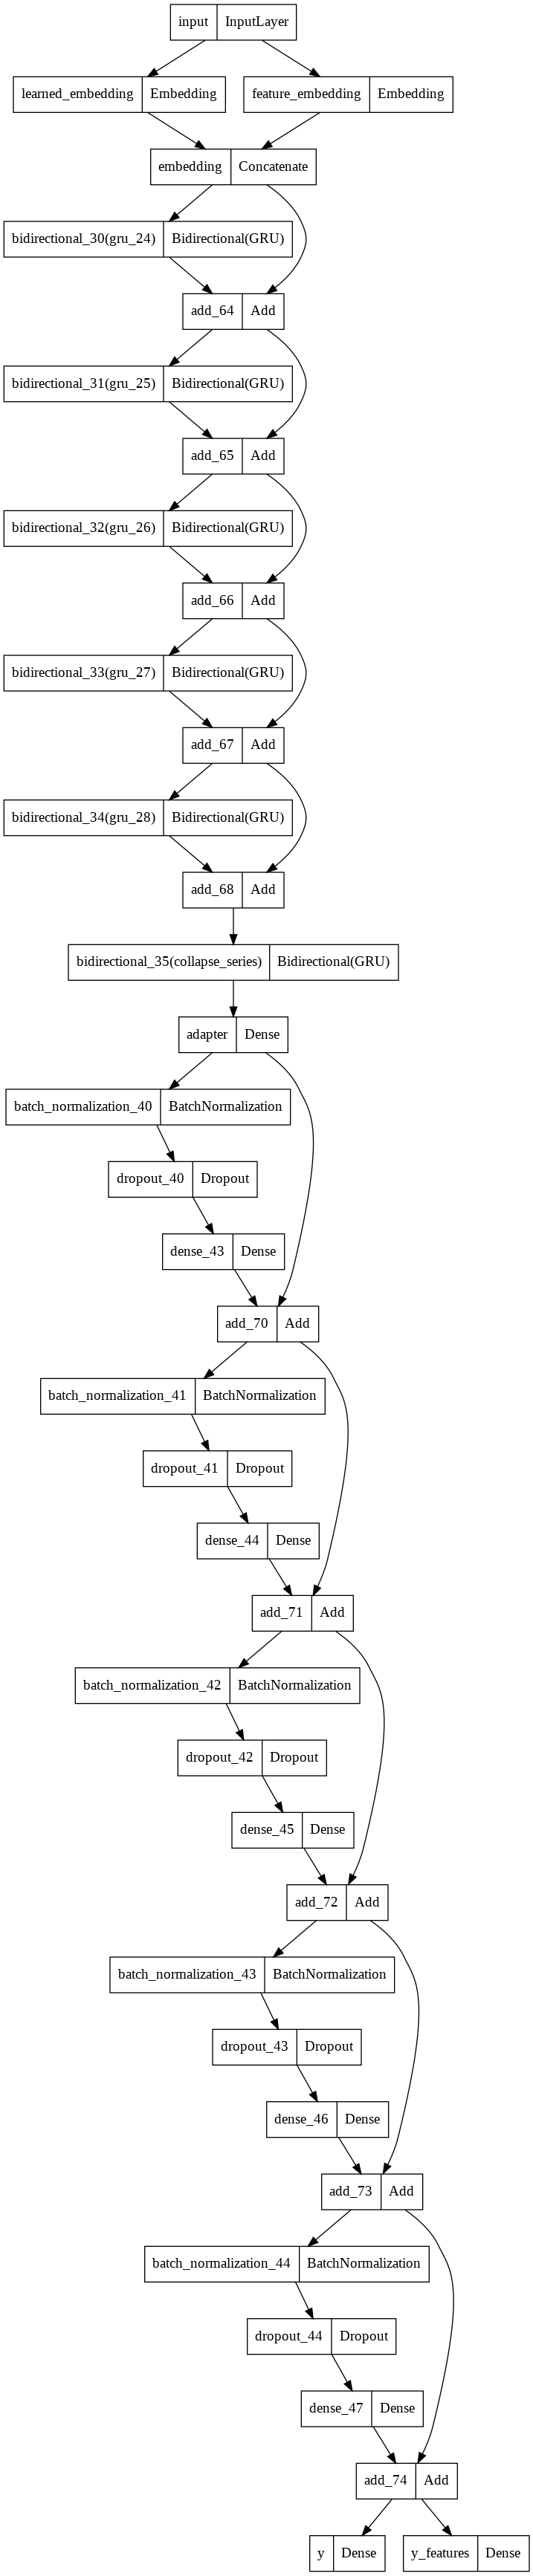

In [ ]:
tf.keras.utils.plot_model(
    model_for_training,to_file="./../model.png")

#Training

In [ ]:
monitor='val_y_accuracy'
model_for_training.fit(
    train_set, 
    #double_train_set,
    validation_data=test_set, 
    batch_size=128,
    epochs=100,
    callbacks=[
              #tf.keras.callbacks.ModelCheckpoint(
              #    filepath='/gdrive/MyDrive/dressipi_recsys2022_mapped/model_transformer_expanded_swish',
              #    monitor=monitor,
              #    save_weights_only=True,
              #    save_best_only=True
              #    ),
               tf.keras.callbacks.EarlyStopping(
                  monitor=monitor,
                  patience=5,
                  restore_best_weights=True,
              )
         ]
    )

# best val_loss: 6.7355 - val_accuracy: 0.0918 - val_sparse_top_k_categorical_accuracy: 0.4986

Epoch 1/100
1563/1563 [==============================] - 277s 150ms/step - loss: 6.2376 - y_loss: 8.4141 - y_features_loss: 1.1592 - y_accuracy: 0.0212 - y_sparse_top_k_categorical_accuracy: 0.2609 - val_loss: 5.7401 - val_y_loss: 7.8328 - val_y_features_loss: 0.8572 - val_y_accuracy: 0.0315 - val_y_sparse_top_k_categorical_accuracy: 0.3582
Epoch 2/100
1563/1563 [==============================] - 224s 142ms/step - loss: 5.6186 - y_loss: 7.6398 - y_features_loss: 0.9024 - y_accuracy: 0.0370 - y_sparse_top_k_categorical_accuracy: 0.3924 - val_loss: 5.4786 - val_y_loss: 7.4728 - val_y_features_loss: 0.8253 - val_y_accuracy: 0.0447 - val_y_sparse_top_k_categorical_accuracy: 0.4326
Epoch 3/100
1563/1563 [==============================] - 223s 142ms/step - loss: 5.3936 - y_loss: 7.3436 - y_features_loss: 0.8436 - y_accuracy: 0.0468 - y_sparse_top_k_categorical_accuracy: 0.4499 - val_loss: 5.3588 - val_y_loss: 7.3084 - val_y_features_loss: 0.8098 - val_y_accuracy: 0.0523 - val_y_sparse_top_k_

#Prepare test predictions


In [ ]:
test_leaderboard_sessions = pd.read_csv(
    '/gdrive/MyDrive/dressipi_recsys2022_mapped/dataset/original_data/test_leaderboard_sessions.csv',
    parse_dates=['date'], 
    infer_datetime_format=True
    )
test_leaderboard_sessions.head()

In [ ]:
test_leaderboard_sessions["item_id"].max()

In [ ]:
test_leaderboard_sessions = test_leaderboard_sessions[['session_id', 'item_id']].groupby(['session_id']).agg(tuple).applymap(list).reset_index()
test_leaderboard_sessions.head()

In [ ]:
x_test_leaderboard = tf.keras.preprocessing.sequence.pad_sequences(
    test_leaderboard_sessions['item_id'], 
    padding='post',
    maxlen=100
)

x_test_leaderboard[0]

In [ ]:
submission_set = tf.data.Dataset.from_tensor_slices(
    (test_leaderboard_sessions['session_id'], x_test_leaderboard)
    ).batch(512)

submission_set.element_spec

In [ ]:
submission_df = pd.DataFrame(
    {
        'session_id':[],
        'code':[],
        'rank':[]
    }
)

submission_df.head()

In [ ]:
for session_ids, sessions in submission_set:
  prediction = pd.DataFrame(
      {
        'session_id':session_ids,
         #TODO fix prediction model to only output candidate items
        'code':[tuple(prediction) for prediction in tf.math.top_k(model(sessions)[...,:4991], k=100).indices.numpy()],
        'rank':[tuple([rank for rank in range(1, 101)]) for session in sessions]
     }
    )

  submission_df = pd.concat([submission_df, prediction])
  
submission_df.head()

In [ ]:
print(len(submission_df))

In [ ]:
submission_df = submission_df.explode(['code', 'rank']).astype(int)

submission_df.head()

In [ ]:
mapping= pd.read_csv('/gdrive/MyDrive/dressipi_recsys2022_mapped/dataset/processed_data/map.csv')
submission_df=submission_df.merge(mapping,on="code",how="left")
del submission_df["code"]
submission_df=submission_df[["session_id","item_id","rank"]]

In [ ]:
print(len(submission_df))

In [ ]:
submission_df.info()

In [ ]:
submission_df.isna().sum()

In [ ]:
submission_df.to_csv(
    '/gdrive/MyDrive/dressipi_recsys2022_mapped/leaderboard_submission.csv',
    index=False
    )